## Step 1: Getting data: Safari

In [1]:
import os.path
import subprocess

#choose your own path to save the data to
user_path=os.path.expanduser('~')
data_path = user_path+'/ml_data/safari_browse_history/visits.csv'

#Execute importSafariHistory(user_path) from python with admin permissions
#or copy the History Safari file manually from the commandline
#cp ~/Library/Safari/History.db /Users/maximiliamgierschmann/workspace-local/MachineLearning/ML-kaggle/hs.db
# def importSafariHistory(user_path):
#     command = 'cp ~/Library/Safari/History.db ./hs.db'
#     #stream = subprocess.call(command, shell=True)
#     stream = os.popen(bashCommand)
#     stream.close()
#     print("Output:")

#saveHistoryFromSQLite3 reads the data from yours hd.db and queries your history 
def saveHistoryFromSQLite3(path):
    bashCommand = 'sqlite3 -header -csv hs.db \
    \"SELECT I.url, datetime(V.visit_time + 978307200, \'unixepoch\', \'localtime\') as datetime \
    FROM history_items as I, \
    (SELECT history_item, title, visit_time FROM history_visits) as V \
    WHERE I.id = V.history_item ORDER BY datetime desc;\" >'+path
    stream = os.popen(bashCommand)
    stream.close()
    
#checkPath checks for the created csv file. 
def checkPath(path):
    if not os.path.isfile(path):
        print('File does not exist, path:'+path)
    else:
        print("Setup Complete")
        
saveHistoryFromSQLite3(data_path)
checkPath(data_path)

Setup Complete


## Step 2: Pre-processing

In [2]:
import pandas as pd
import datetime

X = pd.read_csv(data_path, parse_dates=['datetime'], index_col= ['datetime'])

#Split current datime into new columns for year, month, day, hour
# Reset our index so datetime becomes a column
X.reset_index(inplace=True)
X['second'] = X['datetime'].dt.second
X['minute'] = X['datetime'].dt.minute
X['hour'] = X['datetime'].dt.hour
X['day'] = X['datetime'].dt.day
X['month'] = X['datetime'].dt.month
X['year'] = X['datetime'].dt.year
X = X.sort_index(level=1)

print(X.head())

             datetime                                                url  \
0 2020-10-08 17:50:23  https://www.amazon.com/-/es/gp/cart/view.html?...   
1 2020-10-08 17:50:10  https://www.amazon.com/-/es/gp/cart/view.html?...   
2 2020-10-08 17:49:08  https://www.farmatodo.com.ve/buscar?producto=j...   
3 2020-10-08 17:49:08  https://www.farmatodo.com.ve/buscar?producto=j...   
4 2020-10-08 17:49:08  https://www.farmatodo.com.ve/buscar?producto=j...   

   second  minute  hour  day  month  year  
0      23      50    17    8     10  2020  
1      10      50    17    8     10  2020  
2       8      49    17    8     10  2020  
3       8      49    17    8     10  2020  
4       8      49    17    8     10  2020  


## Step 3: Analysis

### 1. Daily visits per day

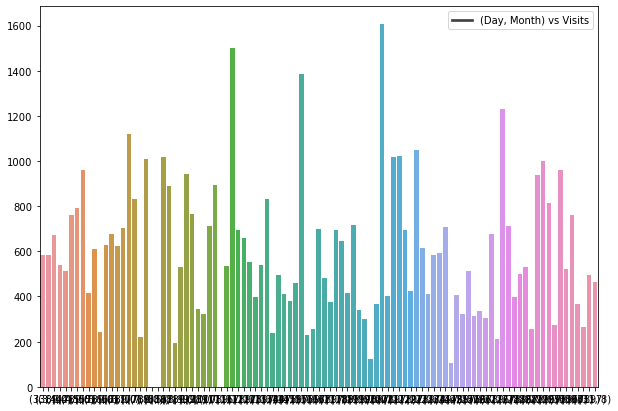

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,7))
#Query for daily visits per day : Grouping-->Sorting-->filtering
daily_visits = X.groupby(['day','month']).day.count()
daily_visits = daily_visits.iloc[9:]
daily_visits_plot=sns.barplot(daily_visits.index, daily_visits.values)
daily_visits_plot.legend(labels=['(Day, Month) vs Visits'])

### 2. Percentage of visits divided per site

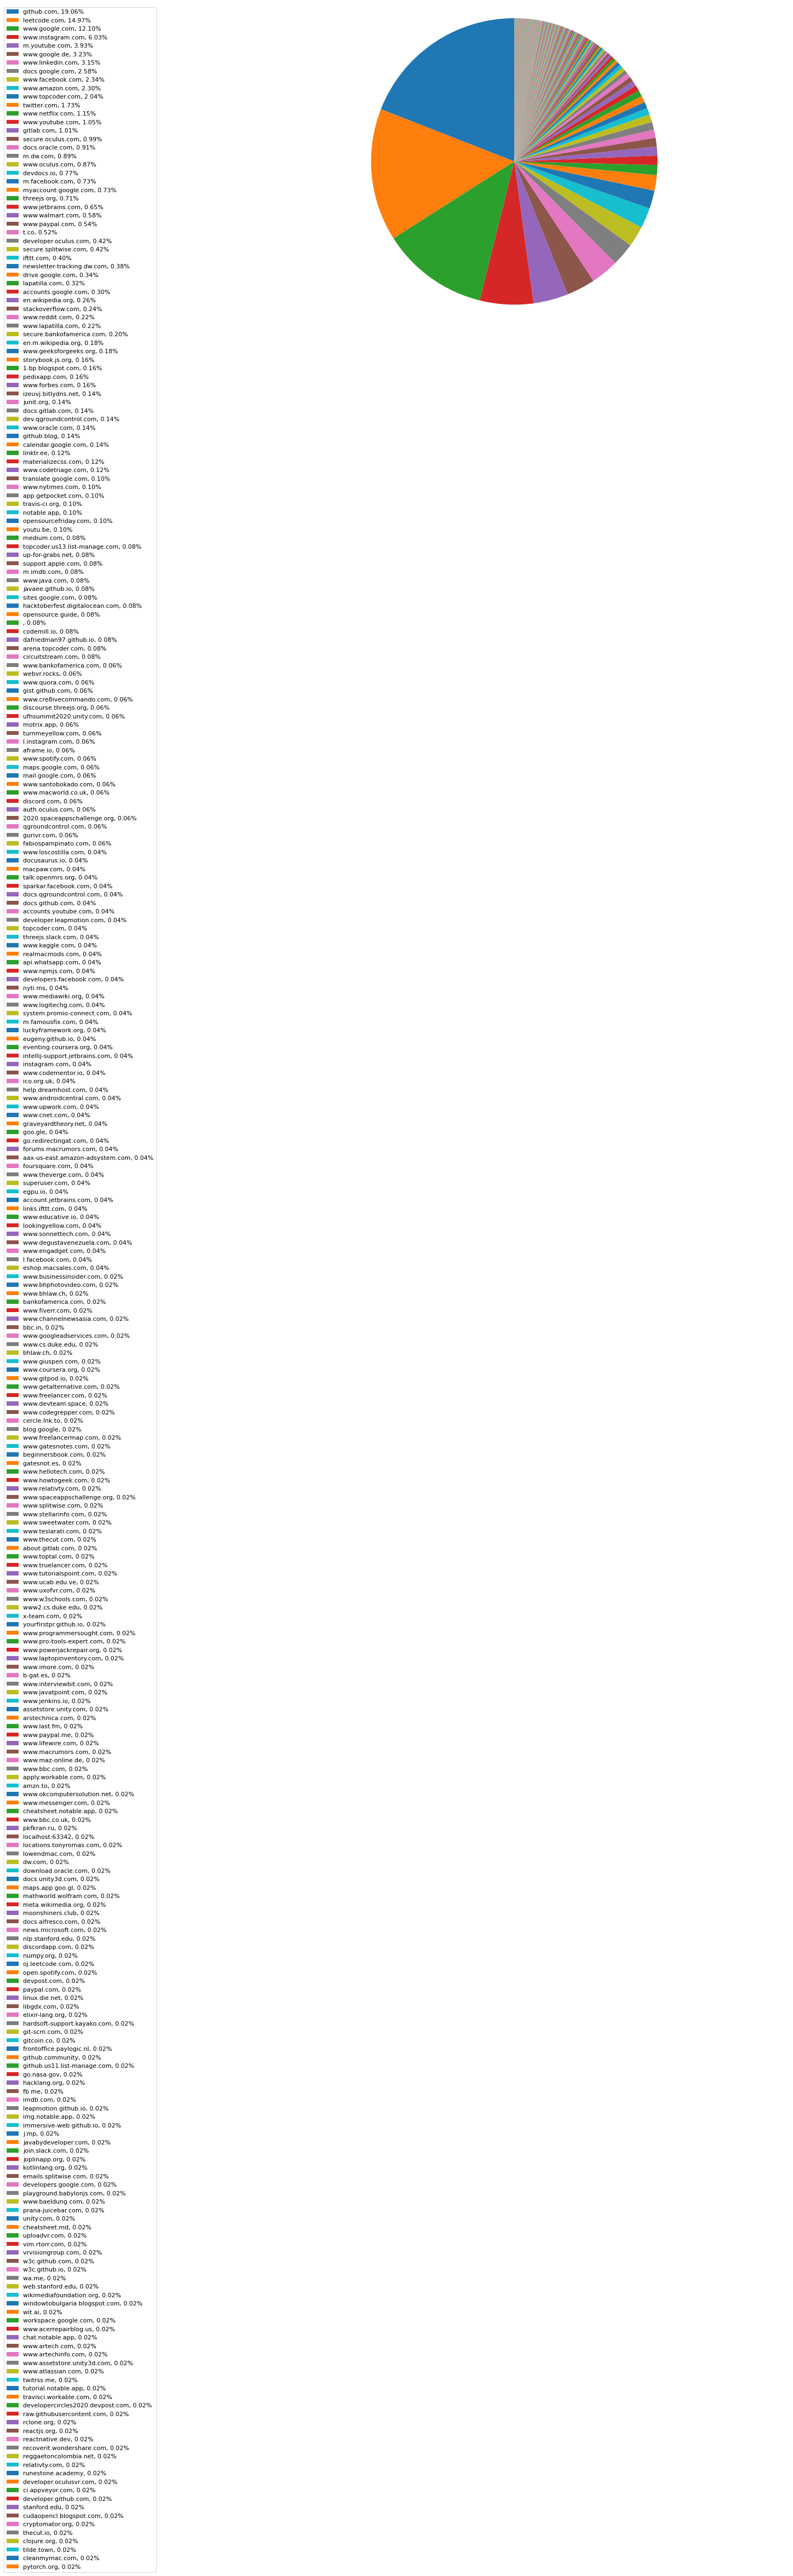

,visits
url,
github.com,945
leetcode.com,742
www.google.com,600
www.instagram.com,299
m.youtube.com,195
www.google.de,160
www.linkedin.com,156
docs.google.com,128
www.facebook.com,116


In [6]:
import matplotlib.pyplot as plt
import datetime

#helper function to clean URLs
def clear_url(origin_url):
    x = origin_url.split("/")
    return x[2]
#getting the data
pie_chart_df = X.copy();    

#Filtering only the last week
today = datetime.date.today()
week_ago = today - datetime.timedelta(days=7)
mask = (pie_chart_df['datetime'] >= pd.to_datetime(week_ago)) & (pie_chart_df['datetime'] <= pd.to_datetime(today))
pie_chart_df = pie_chart_df.loc[mask]


#Cleanning the URLs
pie_chart_df['url'] = pie_chart_df['url'].apply(clear_url)
pie_chart_df = pie_chart_df.groupby(['url']).count()

#Renamming cols after cleanning and groupping 
pie_chart_df = pie_chart_df.drop(['second', 'minute','year','day','hour','month'], axis=1)
pie_chart_df = pie_chart_df.rename(columns={"url": "Website", "datetime": "visits"})
pie_chart_df = pie_chart_df.sort_values(['visits'], ascending=False)

#print(pie_chart_df.head(10))

# Drawing Pie chart
fig1, ax1 = plt.subplots(figsize=(20, 8))
fig1.subplots_adjust(0.3,0,1,1)
labels = pie_chart_df.index
sizes = pie_chart_df['visits']
total = sum(sizes)
theme = plt.get_cmap('bwr')
_, _ = ax1.pie(sizes, startangle=90)
ax1.axis('equal')
plt.legend(
    loc='upper left',
    labels=['%s, %1.2f%%' % (
        l, (float(s) / total) * 100) for l, s in zip(labels, sizes)],
    prop={'size': 11},
    bbox_to_anchor=(0.0,1),
    bbox_transform=fig1.transFigure
)
plt.show()

#printing the table with the number of top 20 visits
pie_chart_df.head(20)